In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [139]:
runlist = np.arange(43,98,1)
#runlist = [43]
Loaddir = '../Claudio/Reduced_RIXS/'
##############################################3
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*npy*'.format(run))[0])
    except:
        print("Some runs are missing")
#check

Will load 55 runs: [43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90
 91 92 93 94 95 96 97] from ../Claudio/Reduced_RIXS/


In [140]:
matrix_avg_on = []
matrix_avg_off = []

for index, run in enumerate(runlist):
    matrix_on = {}
    matrix_off = {}
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for run_key in run_array.keys():
        runnumber = run_array[run_key]["name"].split('-')[0]        
        Energy_eV = run_array[run_key]["Energy_eV"]
        spectra_on = run_array[run_key]["spectra_on"]
        spectra_off = run_array[run_key]["spectra_off"]
        ROIs = run_array[run_key]["ROIs"]
        meta = run_array[run_key]["meta"]
    
    for key in ROIs:
        m_on=[]
        m_off=[]
        for index_step in range(len(spectra_on)):
            m_on.append(spectra_on[index_step][key])
            m_off.append(spectra_off[index_step][key])
        matrix_on[key] = m_on
        matrix_off[key] = m_off
        
    matrix_avg_on.append(matrix_on)
    matrix_avg_off.append(matrix_off)
 

In [113]:
def rebin2D(arr, axis, bin_):
    arr = np.array(arr)
    arr_new=[]
    if axis == 1:
        arr=arr.T
    for index in range(len(arr)):
        cut=arr[index]
        new=bin_sum(cut,bin_)
        arr_new.append(new)
    arr_new=np.array(arr_new)
    if axis == 1:
        arr_new=arr_new.T
    return arr_new

def plot_tool_2D(matrix_ON, matrix_OFF, axis, x_axis, bin_):
    
    matrix_on_rebin  = rebin2D(matrix_ON, axis, bin_)
    matrix_off_rebin = rebin2D(matrix_OFF, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_on_rebin, matrix_off_rebin#, low_err, high_err

def plot_tool_static_2D(matrix, axis, x_axis, bin_):
    
    matrix_rebin  = rebin2D(matrix, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_rebin

In [141]:
len(matrix_avg_on)

55

In [334]:
key_sig = 'JF02T09V03:ROI_KbDW'
key_bkg = 'JF02T09V03:ROI_KbDW_bkg'

key_sig = 'JF02T09V03:ROI_KbUP'
key_bkg = 'JF02T09V03:ROI_KbUP_bkg'


t_on=[]
t_off=[]

for index in range(len(matrix_avg_on)):
    #t_on.append(np.array(matrix_avg_on[index][key_sig]) - np.array(matrix_avg_on[index][key_bkg]))
    #t_off.append(np.array(matrix_avg_off[index][key_sig]) - np.array(matrix_avg_off[index][key_bkg]))
    
    t_on.append(np.array(matrix_avg_on[index][key_sig]))# - np.array(matrix_avg_on[index][key_bkg]))
    t_off.append(np.array(matrix_avg_off[index][key_sig]))# - np.array(matrix_avg_off[index][key_bkg]))
    

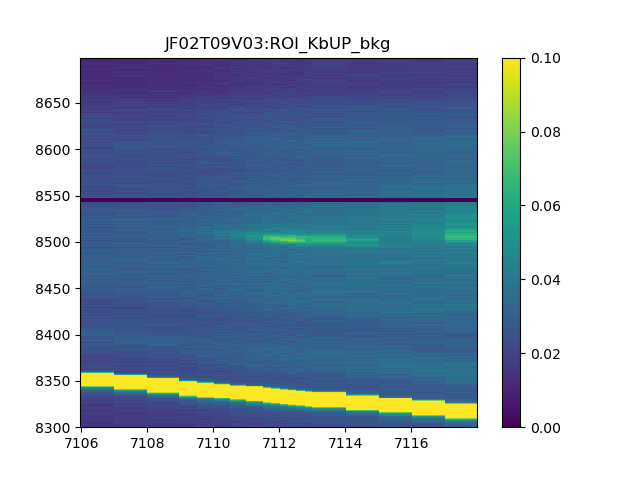

In [335]:
bin_ = 1
vmax = 0.1
vmin = 0


t_on_avg = np.average(t_on, axis = 0)
t_off_avg = np.average(t_off, axis = 0)

plt.figure()
plt.title(key)
yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
y_axis_rebin, matrix_on_rebin = plot_tool_static_2D(t_on_avg, 0, yaxis, bin_)
y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(t_off_avg, 0, yaxis, bin_)

#plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin-matrix_off_rebin)), vmax=vmax, vmin=vmin)
plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin)), vmax=vmax, vmin=vmin)
#plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmax=vmax, vmin=vmin)
plt.colorbar()
plt.show()

In [336]:
data_on = np.transpose(np.asarray(matrix_on_rebin))
data_off = np.transpose(np.asarray(matrix_off_rebin))

np.shape(data)

(400, 20)

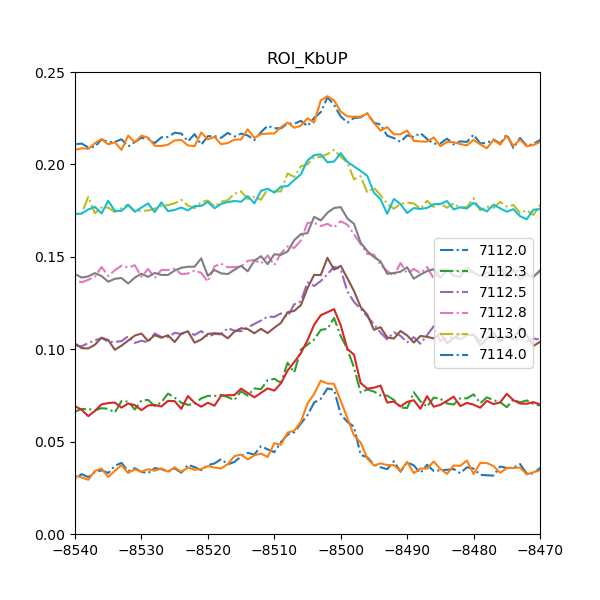

In [352]:
cut = 6
k =0.035
#k =0.5
plt.figure(figsize=(6, 6))
plt.clf()

plt.title(Energy_eV[cut])
for index, cut in enumerate(np.arange(10,16,1)):
    #plt.plot(y_axis_rebin, data_on[:,cut]/np.max(data_on[:,cut]), label = '{:.2f}'.format(Energy_eV[cut]))
    #plt.plot(y_axis_rebin, data_off[:,cut]/np.max(data_off[:,cut]), label = '{:.2f}'.format(Energy_eV[cut]))
    plt.plot(-y_axis_rebin, data_on[:,cut]+k*index, '-.', label = '{:.1f}'.format(Energy_eV[cut]))
    plt.plot(-y_axis_rebin, data_off[:,cut]+k*index)
    plt.legend(loc='right')
plt.ylim(0,0.25)
#plt.xlim(-8475, -8425) #KBDWN
plt.xlim(-8540, -8470) #KBUP
plt.title('ROI_KbUP')
plt.show()

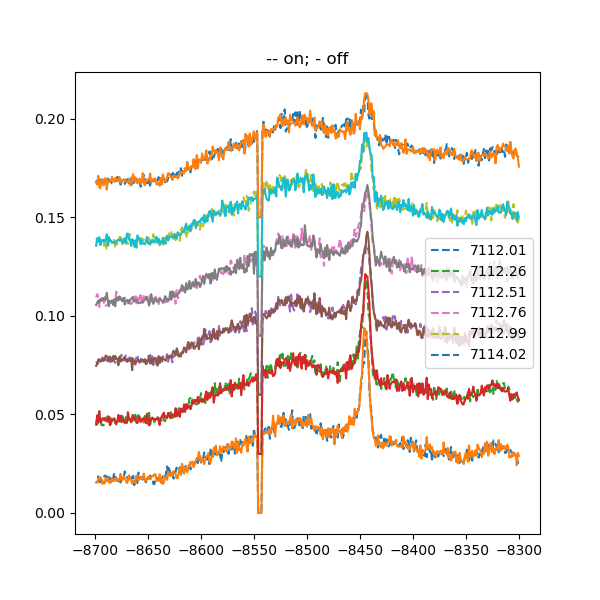

In [314]:
cutlist = 10
k =0.03
plt.figure(figsize=(6, 6))
plt.clf()

plt.title(Energy_eV[cut])
for index, cut in enumerate(np.arange(10,16,1)):
    #plt.plot(y_axis_rebin, data_on[:,cut]/np.max(data_on[:,cut]), label = '{:.2f}'.format(Energy_eV[cut]))
    #plt.plot(y_axis_rebin, data_off[:,cut]/np.max(data_off[:,cut]), label = '{:.2f}'.format(Energy_eV[cut]))
    plt.plot(-y_axis_rebin, data_on[:,cut]+k*index, '--', label = '{:.2f}'.format(Energy_eV[cut]))
    plt.plot(-y_axis_rebin, data_off[:,cut]+k*index)
    plt.legend(loc='right')
#plt.ylim(0,0.1)
#plt.xlim(-8475, -8425)
plt.title('-- on; - off')
plt.show()

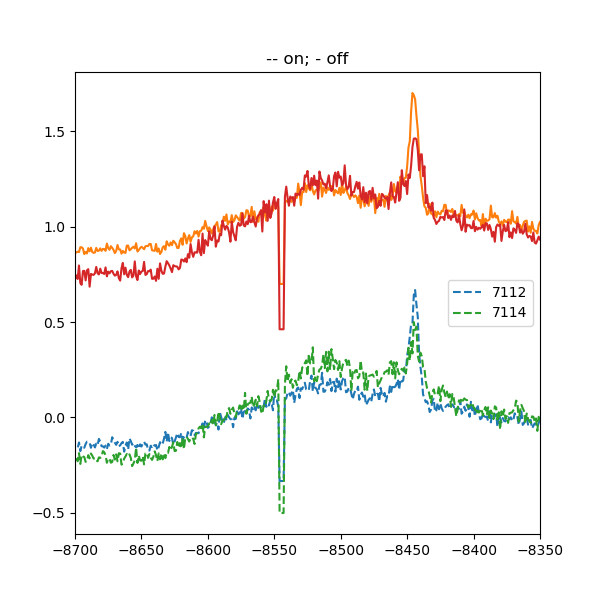

In [319]:
cutlist = 10,15
k =1
plt.figure(figsize=(6, 6))

#plt.title(Energy_eV[cut])
for cut in cutlist:
    data_on1 =data_on[:,cut]/ np.max(data_on[:,cut])
    data_off1 =data_off[:,cut]/ np.max(data_off[:,cut])
    #data_on[:,cut] =data_on[:,cut]/ np.trapz(data_on[:,cut])
    #data_off[:,cut] =data_off[:,cut]/ np.trapz(data_off[:,cut])
    
    data_on1 = data_on1-data_on1[7]
    data_off1= data_off1-data_off1[7]
    #plt.plot(y_axis_rebin, data_on[:,cut]/np.max(data_on[:,cut]), label = '{:.2f}'.format(Energy_eV[cut]))
    #plt.plot(y_axis_rebin, data_off[:,cut]/np.max(data_off[:,cut]), label = '{:.2f}'.format(Energy_eV[cut]))
    plt.plot(-y_axis_rebin, data_on1, '--', label = '{:.0f}'.format(Energy_eV[cut]))
    plt.plot(-y_axis_rebin, data_off1+k)
    plt.legend(loc='right')
#plt.ylim(0,2.3)
plt.xlim(-8700, -8350)
plt.title('-- on; - off')
plt.show()

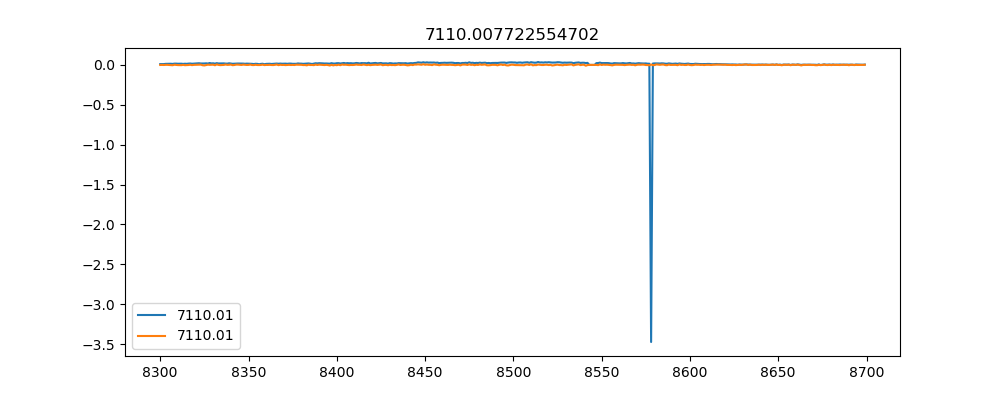

In [86]:
cut = 5

plt.figure(figsize=(10, 4))

plt.title(Energy_eV[cut])
plt.plot(y_axis_rebin, data_pump[:,cut], label = '{:.2f}'.format(Energy_eV[cut]))

plt.plot(y_axis_rebin, data[:,cut], label = '{:.2f}'.format(Energy_eV[cut]))
plt.legend(loc='best')
plt.show()

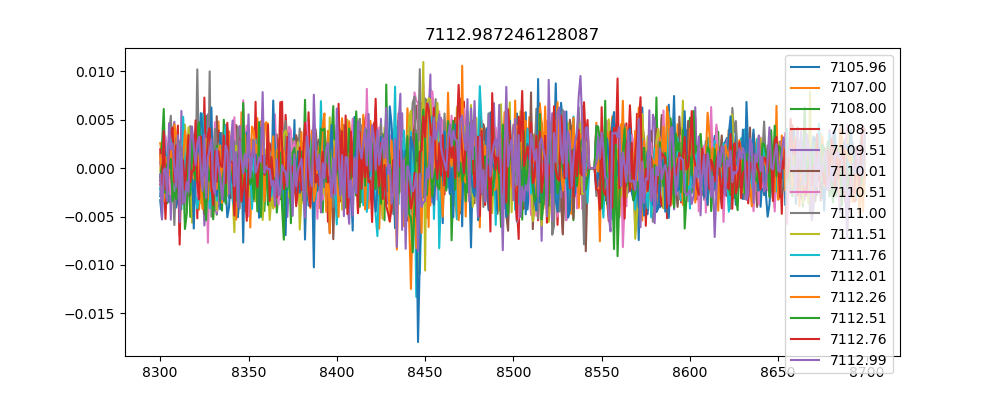

In [76]:
cut = 7

plt.figure(figsize=(10, 4))
for cut in range(15):
    plt.title(Energy_eV[cut])
    plt.plot(y_axis_rebin, data[:,cut], label = '{:.2f}'.format(Energy_eV[cut]))
    plt.legend(loc='best')
plt.show()

In [47]:
t=np.mean(test[0][0]['JF02T09V03:ROI_KbDW'])
t

0.027390443

In [37]:
for index_run in range(len(test)):
    for key in ROIs:
        spectra_on=np.average(test[index_run][:][key], axis=0)

TypeError: list indices must be integers or slices, not str

In [35]:
np.shape(spectra_on)

()

## check data files

# Plotting timescans WITHOUT timetool
## (for TT correction go below)

In [60]:
roi_array = ['spectrum_roi1_ON', 'spectrum_roi1_OFF', 
             'spectrum_roi2_ON', 'spectrum_roi2_OFF',
             'spectrum_roi3_ON', 'spectrum_roi3_OFF',
             'spectrum_roi4_ON', 'spectrum_roi4_OFF',]

for spec in roi_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    print (len(datafiles))
    #print (patch)
    spec2save = []
    for ff in datafiles:
        temp = np.load(ff, allow_pickle=True)
        spectrum_temp = []
        for index in range(len(temp)):
            #spectrum_temp.append(np.average(temp[index], axis =0))
            spectrum_temp.append(temp[index])
        #spec2save = (spec2save + np.asarray(spectrum_temp))
        spec2save.append(spectrum_temp)
    spec2save = np.average(spec2save, axis=0)
    print (np.shape(spec2save))
    np.save(Loaddir+spec+'_all.npy', spec2save)

2
(51, 200)
2
(51, 200)
2
(51, 200)
2
(51, 200)
2
(51, 100)
2
(51, 100)
2
(51, 100)
2
(51, 100)


In [61]:
spectrum_roi1_ON = np.load(Loaddir+'/spectrum_roi1_ON_all.npy')
spectrum_roi1_OFF = np.load(Loaddir+'/spectrum_roi1_OFF_all.npy')
spectrum_roi2_ON = np.load(Loaddir+'/spectrum_roi2_ON_all.npy')
spectrum_roi2_OFF = np.load(Loaddir+'/spectrum_roi2_OFF_all.npy')
spectrum_roi3_ON = np.load(Loaddir+'/spectrum_roi3_ON_all.npy')
spectrum_roi3_OFF = np.load(Loaddir+'/spectrum_roi3_OFF_all.npy')
spectrum_roi4_ON = np.load(Loaddir+'/spectrum_roi4_ON_all.npy')
spectrum_roi4_OFF = np.load(Loaddir+'/spectrum_roi4_OFF_all.npy')

200 100


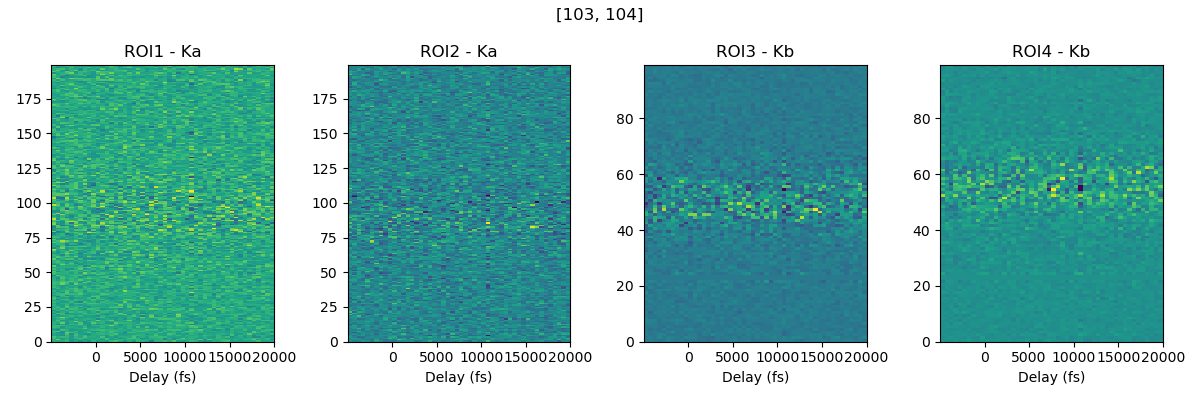

In [62]:
xaxis12 = np.arange(0,len(np.load(Loaddir+'/spectrum_roi1_ON_all.npy')[0]))
xaxis34 = np.arange(0,len(np.load(Loaddir+'/spectrum_roi3_ON_all.npy')[0]))
print (len(xaxis12), len(xaxis34))

Delay_fs = np.load(glob.glob(Loaddir+'/*{:04d}*/delays_fs.npy'.format(runlist[0]))[0])

plt.figure(figsize=(12,4))
plt.suptitle(str(runlist))
plt.subplot(141)
plt.title('ROI1 - Ka')
plt.pcolormesh(Delay_fs, xaxis12, np.transpose(spectrum_roi1_ON-spectrum_roi1_OFF))
plt.xlabel('Delay (fs)')

plt.subplot(142)
plt.title('ROI2 - Ka')
plt.pcolormesh(Delay_fs, xaxis12, np.transpose(spectrum_roi2_ON-spectrum_roi2_OFF))
plt.xlabel('Delay (fs)')

plt.subplot(143)
plt.title('ROI3 - Kb')
plt.pcolormesh(Delay_fs, xaxis34, np.transpose(spectrum_roi3_ON-spectrum_roi3_OFF))
plt.xlabel('Delay (fs)')

plt.subplot(144)
plt.title('ROI4 - Kb')
plt.pcolormesh(Delay_fs, xaxis34, np.transpose(spectrum_roi4_ON-spectrum_roi4_OFF))
plt.xlabel('Delay (fs)')

plt.tight_layout()
plt.show()

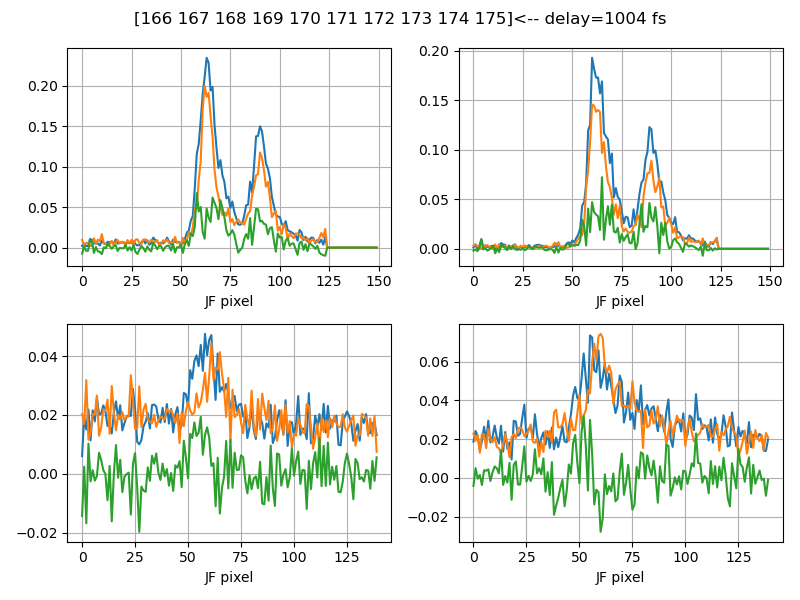

In [101]:
chosendelay = 1000

#############################################3
delayindex = np.arange(len(Delay_fs))[(Delay_fs > chosendelay)][0]

specON_array = [spectrum_roi1_ON, spectrum_roi2_ON, spectrum_roi3_ON, spectrum_roi4_ON]
specOFF_array = [spectrum_roi1_OFF, spectrum_roi2_OFF, spectrum_roi3_OFF, spectrum_roi4_OFF]

fig = plt.figure(figsize=(8, 6))
plt.suptitle(str(runlist)+'<-- delay={:.0f} fs'.format(Delay_fs[delayindex]))

for i in range(4):
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(specON_array[i][delayindex])
    ax.plot(specOFF_array[i][delayindex])
    ax.plot(specON_array[i][delayindex] - specOFF_array[i][delayindex])
    plt.grid()
    plt.xlabel('JF pixel')

plt.tight_layout()

In [102]:
data = []
for f in glob.glob(Loaddir+'/spectrum_*'):
    data.append(f)
    data = sorted(data, key = os.path.getmtime)
print (data)
intensity_all=[]
for index in np.arange(0,8,2):
    intensity = []
    map_2D = np.transpose(np.load(data[index])-np.load(data[index+1]))
    for index in np.arange(len(Delay_fs)):
        intensity.append(np.sum(np.abs(map_2D[50:70,index]), axis = 0))
    intensity_all.append(intensity)

['../Claudio/Reduced_TT/spectrum_roi1_ON_all.npy', '../Claudio/Reduced_TT/spectrum_roi1_OFF_all.npy', '../Claudio/Reduced_TT/spectrum_roi2_ON_all.npy', '../Claudio/Reduced_TT/spectrum_roi2_OFF_all.npy', '../Claudio/Reduced_TT/spectrum_roi3_ON_all.npy', '../Claudio/Reduced_TT/spectrum_roi3_OFF_all.npy', '../Claudio/Reduced_TT/spectrum_roi4_ON_all.npy', '../Claudio/Reduced_TT/spectrum_roi4_OFF_all.npy']


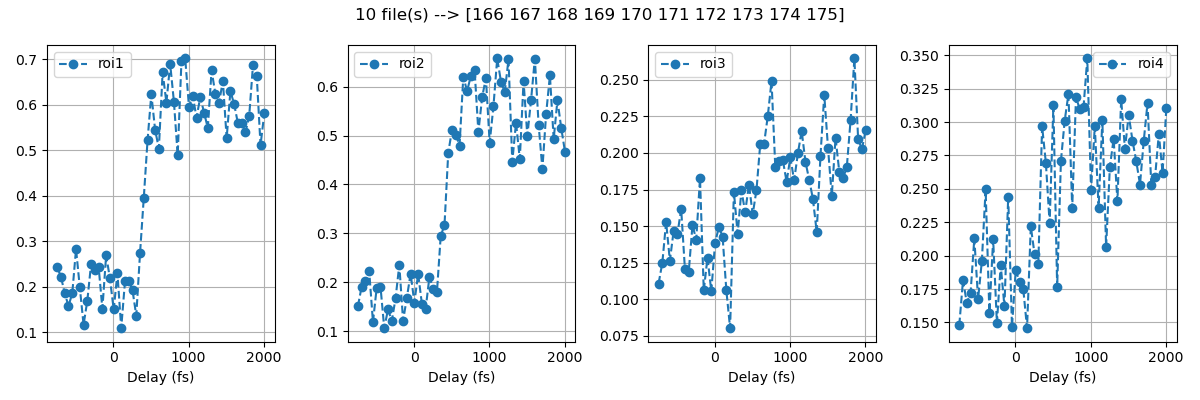

In [103]:
plt.figure(figsize=(12,4))
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

plt.subplot(141)
plt.plot(Delay_fs, intensity_all[0], '--o', label='roi1')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')


plt.subplot(142)
plt.plot(Delay_fs, intensity_all[1],'--o', label='roi2')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')


plt.subplot(143)
plt.plot(Delay_fs, intensity_all[2],'--o',  label='roi3')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')

plt.subplot(144)
plt.plot(Delay_fs, intensity_all[3],'--o', label='roi4')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')

plt.tight_layout()
plt.show()

In [104]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

In [105]:
intensity = np.array(intensity_all[1])

fit.estimate(Delay_fs, intensity)            # this sets some internal params 
#print(fit.p0)
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 
#fit.p0 =[272.1, 0.08, 100, 0.01, 200, 0, 0.05]

fit.fit(Delay_fs,intensity)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting

#t0_fs = fit.popt[0]
#t0_mm = timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Width ={:.2f}".format(np.abs(width_fs),"fs"))

Width =208.93


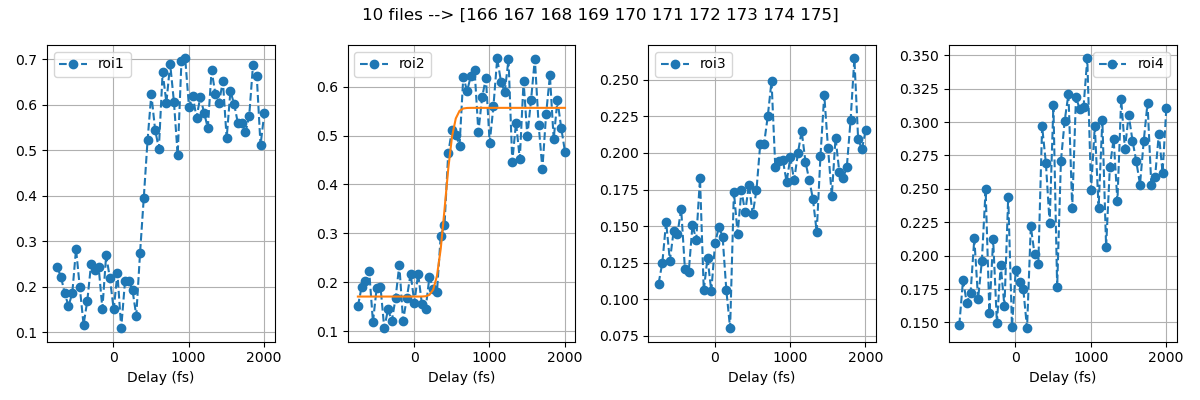

In [106]:
plt.figure(figsize=(12,4))
plt.suptitle('{} files --> {}'.format(len(runlist),str(runlist)))

plt.subplot(141)
plt.plot(Delay_fs, intensity_all[0], '--o', label='roi1')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')


plt.subplot(142)
plt.plot(Delay_fs, intensity_all[1],'--o', label='roi2')
plt.plot(Delay_fs, pp_fit)
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')


plt.subplot(143)
plt.plot(Delay_fs, intensity_all[2],'--o',  label='roi3')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')

plt.subplot(144)
plt.plot(Delay_fs, intensity_all[3],'--o', label='roi4')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')
plt.tight_layout()
plt.show()

# Plotting timescans WITH timetool

In [12]:
runlist

array([166, 167, 168, 169, 170, 171, 172, 173, 174, 175])

In [13]:
roi_array = ['spectrum_roi1_ON', 'spectrum_roi1_OFF', 
             'spectrum_roi2_ON', 'spectrum_roi2_OFF',
             'spectrum_roi3_ON', 'spectrum_roi3_OFF',
             'spectrum_roi4_ON', 'spectrum_roi4_OFF',]

for spec in roi_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    patch = datafiles
    print (len(patch))
    #print (patch)
    #### Load ON/OFF the spectra for different runs and save them #####
    spec2save = []
    for ff in patch:
        temp = np.load(ff, allow_pickle=True)
        temp = np.asarray(list(itertools.chain.from_iterable(temp)))
        spec2save.append(temp)
    spec2save = np.asarray(list(itertools.chain.from_iterable(spec2save)))
    print (np.shape(spec2save))
    np.save(Loaddir+spec+'_all.npy', spec2save)
    
delayfiles = []
for run in runlist:
    delayfile = glob.glob(Loaddir + '/*{:04d}*/*delays_corr*'.format(run))
    delayfiles.append(delayfile)
delayfiles = itertools.chain.from_iterable(delayfiles)
delayfiles = sorted(delayfiles, key = os.path.getmtime)
print ('{} file(s) found.'.format(len(delayfiles)))
delay2save = []
for df in delayfiles:
    temp = np.load(df, allow_pickle=True)
    delay2save.append(temp)
delay2save = np.asarray(list(itertools.chain.from_iterable(delay2save)))
print (np.shape(delay2save))
np.save(Loaddir+'delays_all_TT.npy', delay2save)

10
(280217, 150)
10
(280239, 150)
10
(280217, 150)
10
(280239, 150)
10
(280217, 140)
10
(280239, 140)
10
(280217, 140)
10
(280239, 140)
10 file(s) found.
(280217,)


In [82]:
binsize = 50
offset = -100

roi1 = (5050, 5200, 130, 290) #signal CRY2 low
roi2 = (5050, 5200, 310, 370) #signan CRY2 up

roi3 = (8400, 8540, 125, 225) #signal CRY1 low
roi4 = (8400, 8540, 250, 350) #signal CRY1 up


Delay_fs_scan = np.load(glob.glob(Loaddir+'/*{:04d}*/delays_stage.npy'.format(runlist[0]))[0])
#Delay_fs_scan = Delay_fs_scan
binList = np.arange(Delay_fs_scan[0] - offset, Delay_fs_scan[-1] + offset, binsize)
#binList = Delay_fs_scan
bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.arange(Delay_fs_scan[0] - offset + binsize/2, Delay_fs_scan[-1] + offset - binsize/2, binsize)

spectrum_roi1_ON = np.load(Loaddir+'/spectrum_roi1_ON_all.npy')
spectrum_roi1_OFF = np.load(Loaddir+'/spectrum_roi1_OFF_all.npy')
spectrum_roi2_ON = np.load(Loaddir+'/spectrum_roi2_ON_all.npy')
spectrum_roi2_OFF = np.load(Loaddir+'/spectrum_roi2_OFF_all.npy')
spectrum_roi3_ON = np.load(Loaddir+'/spectrum_roi3_ON_all.npy')
spectrum_roi3_OFF = np.load(Loaddir+'/spectrum_roi3_OFF_all.npy')
spectrum_roi4_ON = np.load(Loaddir+'/spectrum_roi4_ON_all.npy')
spectrum_roi4_OFF = np.load(Loaddir+'/spectrum_roi4_OFF_all.npy')
Delays_corr_scan = np.load(Loaddir+'/delays_all_TT.npy')

print (np.shape(spectrum_roi1_ON))
print (np.shape(Delays_corr_scan))


#Delay_rebin = np.zeros(len(bin_centres))
spectrum_roi1_on_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi1_ON)[1]))
spectrum_roi2_on_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi2_ON)[1]))
spectrum_roi3_on_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi3_ON)[1]))
spectrum_roi4_on_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi4_ON)[1]))
spectrum_roi1_off_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi1_OFF)[1]))
spectrum_roi2_off_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi2_OFF)[1]))
spectrum_roi3_off_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi3_OFF)[1]))
spectrum_roi4_off_rebin = np.zeros((len(bin_centres), np.shape(spectrum_roi4_OFF)[1]))
check=[]
for i in range(len(bin_centres)):
    cond1 = Delays_corr_scan > binList[i]
    cond2 = Delays_corr_scan < binList[i+1]

    idx = np.where(cond1*cond2)[0]
    check.append(idx)
    #print (len(idx))

    Delay_fs_TT[i] = np.average(Delays_corr_scan[idx])
    
    spectrum_roi1_on_rebin[i] = np.average(spectrum_roi1_ON[idx,:], axis=0)
    spectrum_roi2_on_rebin[i] = np.average(spectrum_roi2_ON[idx,:], axis=0)
    spectrum_roi3_on_rebin[i] = np.average(spectrum_roi3_ON[idx,:], axis=0)
    spectrum_roi4_on_rebin[i] = np.average(spectrum_roi4_ON[idx,:], axis=0)
    spectrum_roi1_off_rebin[i] = np.average(spectrum_roi1_OFF[idx,:], axis=0)
    spectrum_roi2_off_rebin[i] = np.average(spectrum_roi2_OFF[idx,:], axis=0)
    spectrum_roi3_off_rebin[i] = np.average(spectrum_roi3_OFF[idx,:], axis=0)
    spectrum_roi4_off_rebin[i] = np.average(spectrum_roi4_OFF[idx,:], axis=0)
check = np.asarray(list(itertools.chain.from_iterable(check)))
print (len(check))

(280217, 150)
(280217,)
254547


In [83]:
map2D_roi1_rebin = np.transpose(spectrum_roi1_on_rebin-spectrum_roi1_off_rebin)#np.average(spectrum_roi1_OFF,axis=0))
map2D_roi2_rebin = np.transpose(spectrum_roi2_on_rebin-spectrum_roi2_off_rebin)#np.average(spectrum_roi2_OFF,axis=0))
map2D_roi3_rebin = np.transpose(spectrum_roi3_on_rebin-spectrum_roi3_off_rebin)#np.average(spectrum_roi3_OFF,axis=0))
map2D_roi4_rebin = np.transpose(spectrum_roi4_on_rebin-spectrum_roi4_off_rebin)#np.average(spectrum_roi4_OFF,axis=0))
np.save(Loaddir+'map2D_roi1_rebin.npy', map2D_roi1_rebin)
np.save(Loaddir+'map2D_roi2_rebin.npy', map2D_roi2_rebin)
np.save(Loaddir+'map2D_roi3_rebin.npy', map2D_roi3_rebin)
np.save(Loaddir+'map2D_roi4_rebin.npy', map2D_roi4_rebin)

150 140


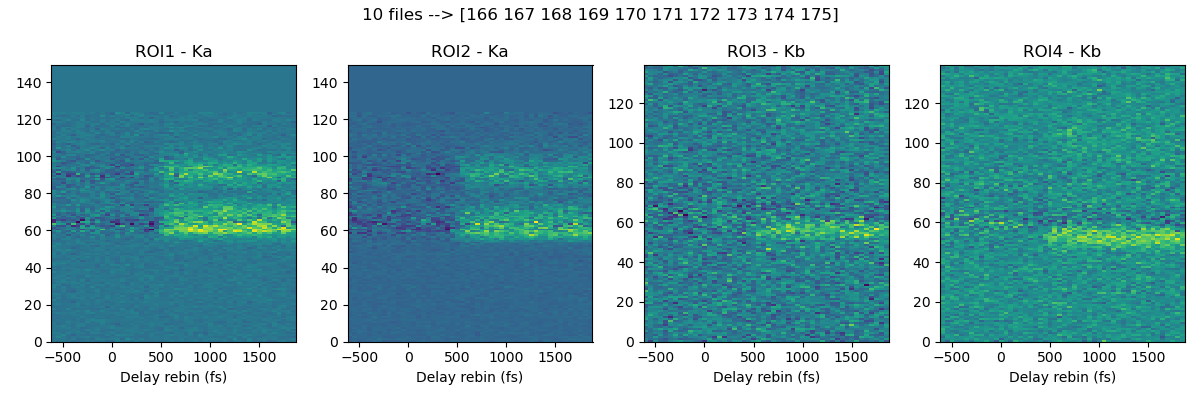

In [84]:
xaxis12 = np.arange(0,np.shape(spectrum_roi1_ON)[1])
xaxis34 = np.arange(0,np.shape(spectrum_roi3_ON)[1])
print (len(xaxis12), len(xaxis34))
#Delay_fs = np.load(Loaddir+'/run0790-FebpyCN4_DMA_7uJ_short_001/delays_fs.npy')
#Delay_fs = np.load(glob(Loaddir+'/*{:04d}*/delays_fs.npy'.format(runlist[0]))[0])

plt.figure(figsize=(12,4))
plt.suptitle('{} files --> {}'.format(len(runlist),str(runlist)))
plt.subplot(141)
plt.title('ROI1 - Ka')
plt.pcolormesh(Delay_fs_TT, xaxis12, map2D_roi1_rebin)
plt.xlabel('Delay rebin (fs)')

plt.subplot(142)
plt.title('ROI2 - Ka')
plt.pcolormesh(Delay_fs_TT, xaxis12, map2D_roi2_rebin)
plt.xlabel('Delay rebin (fs)')

plt.subplot(143)
plt.title('ROI3 - Kb')
plt.pcolormesh(Delay_fs_TT, xaxis34, map2D_roi3_rebin)
plt.xlabel('Delay rebin (fs)')

plt.subplot(144)
plt.title('ROI4 - Kb')
plt.pcolormesh(Delay_fs_TT, xaxis34, map2D_roi4_rebin, vmin=-0.05, vmax=0.05)
plt.xlabel('Delay rebin (fs)')

plt.tight_layout()
plt.show()
#plt.savefig('/das/work/p20/p20537/Claudio/PNG/XES_timescans.PNG')

In [76]:
np.shape(Delay_fs_TT)

(127,)

In [87]:
Delay_fs_TT[30]

878.9914888398062

In [57]:
np.shape(np.sum(map2D_roi4_rebin[:,20:30], axis = 1))

(140,)

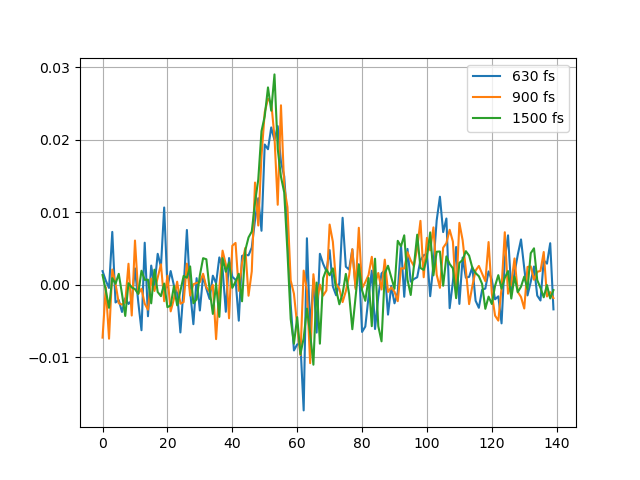

In [91]:
plt.figure()
#plt.plot(np.sum(map2D_roi4_rebin[:,10:20], axis=1))
plt.plot(np.average(map2D_roi4_rebin[:,22:27], axis=1), label='630 fs')
plt.plot(np.average(map2D_roi4_rebin[:,27:32], axis=1), label='900 fs')
plt.plot(np.average(map2D_roi4_rebin[:,40:50], axis=1), label='1500 fs')
plt.legend (loc='best')
plt.grid()

plt.show()
plt.savefig('/das/work/p20/p20537/Claudio/PNG/Kb_timetraces.PNG')

In [37]:
data = []
for f in glob.glob(Loaddir+'*rebin*'):
    data.append(f)
    data = sorted(data, key = os.path.getmtime)
print (data)
intensity_all_TT=[]
for index in np.arange(len(data)):
    map_2D = np.load(data[index])
    print (np.shape(map_2D))
    intensity = []
    for delayindex in np.arange(len(Delay_fs_TT)):
        intensity.append(np.sum(np.abs(map_2D[50:75,delayindex]), axis = 0))
    intensity_all_TT.append(intensity)

['../Claudio/Reduced_TT/map2D_roi1_rebin.npy', '../Claudio/Reduced_TT/map2D_roi2_rebin.npy', '../Claudio/Reduced_TT/map2D_roi3_rebin.npy', '../Claudio/Reduced_TT/map2D_roi4_rebin.npy']
(150, 51)
(150, 51)
(140, 51)
(140, 51)


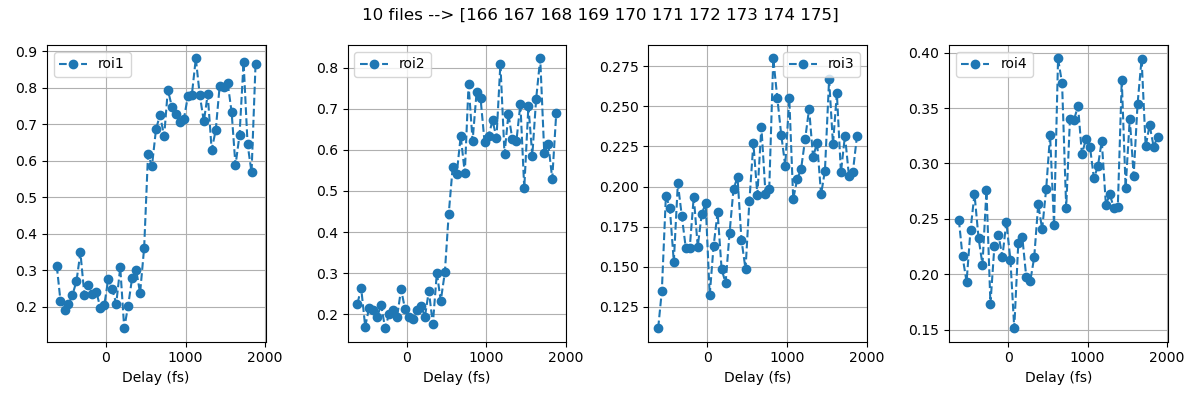

In [38]:
plt.figure(figsize=(12,4))
plt.suptitle('{} files --> {}'.format(len(runlist),str(runlist)))

plt.subplot(141)
plt.plot(Delay_fs_TT, intensity_all_TT[0], '--o', label='roi1')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')

plt.subplot(142)
plt.plot(Delay_fs_TT, intensity_all_TT[1],'--o', label='roi2')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')


plt.subplot(143)
plt.plot(Delay_fs_TT, intensity_all_TT[2],'--o',  label='roi3')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')

plt.subplot(144)
plt.plot(Delay_fs_TT, intensity_all_TT[3],'--o', label='roi4')
#plt.plot(Delay_fs, intensity_all[3],'--o', label='roi4')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')
plt.tight_layout()
plt.show()

In [39]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

In [40]:
intensity = np.array(intensity_all_TT[0])

fit.estimate(Delay_fs_TT, intensity)            # this sets some internal params 
#print(fit.p0)
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 
#fit.p0 =[272.1, 0.08, 100, 0.01, 200, 0, 0.05]

fit.fit(Delay_fs_TT,intensity)                  # calculate the fit
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

#t0_fs = fit.popt[0]
#t0_mm = timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Width ={:.2f}".format(np.abs(width_fs),"fs"))

Width =169.19


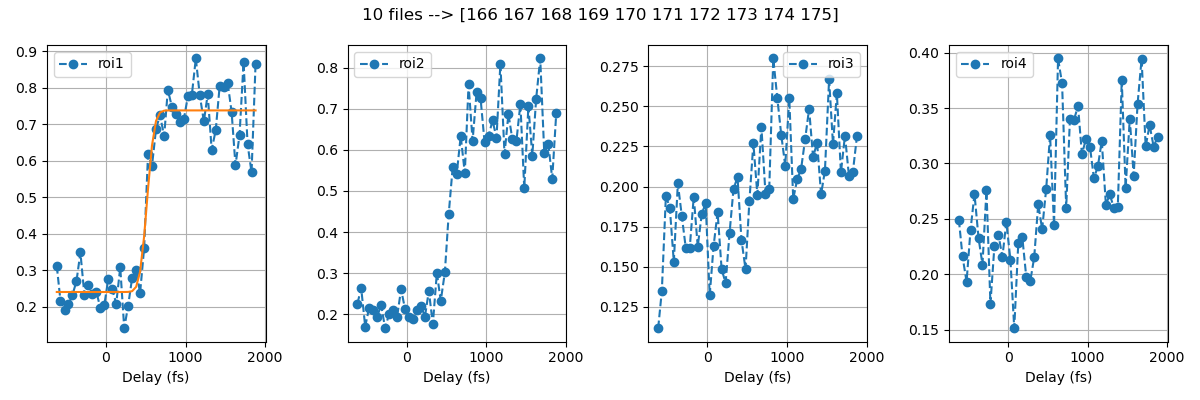

In [42]:
plt.figure(figsize=(12,4))
plt.suptitle('{} files --> {}'.format(len(runlist),str(runlist)))

plt.subplot(141)
plt.plot(Delay_fs_TT, intensity_all_TT[0], '--o', label='roi1')
plt.plot(Delay_fs_TT, pp_fit)
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')

plt.subplot(142)
plt.plot(Delay_fs_TT, intensity_all_TT[1],'--o', label='roi2')

plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')


plt.subplot(143)
plt.plot(Delay_fs_TT, intensity_all_TT[2],'--o',  label='roi3')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')

plt.subplot(144)
#plt.plot(Delay_fs, intensity_all[3],'--o', label='roi4')
plt.plot(Delay_fs_TT, intensity_all_TT[3],'--o', label='roi4')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')
plt.tight_layout()
plt.show()
#plt.savefig('/das/work/p20/p20537/Claudio/PNG/Ka_risetime.PNG')